# Mushroom classification by pre-trained neural networks

The project uses the mushroom images' dataset uploaded from the Kaggle website (https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images). The dataset contains 6714 images of mushrooms. The dataset is divided into 9 folders, each of them containing images of mushrooms of a separate class. There are nine classes of mushrooms in the dataset in total: Agaricus, Amanita, Boletus, Cortinarius, Entoloma, Hygrocybe, Lactarius, Russula, Suillus. 

The purpose of the project is to apply transfer learning for training classifiers which would be able to corectly classify mushrooms - that is, to provide labels to images of various mushrooms, coresponding to their actual classes. 

The project consists of two parts: 1) the exploratory analysis of the dataset of mushroom images and 2) building, training, fine-tuning and evaluating classifiers able to predict mushroom classes as well as predicting mushroom classes based on the trained models. 

### Importing libraries

The main libraries which will be used for the manipulation with data are pandas and numpy. Matplotlib and seaborn will be used for data visualization. Various modules of the torch library as well as pytorch-lightning will be used for data loading, importing pretrained models, training, summarizing and fine-tuning. Sklearn metrics will be used for presenting confusion matrix and classification report. 

The modelling was performed on the Mac computer with the M2 processor (10 GPU cores), thus the pytorch-lighhtning library rather than the fastai library was chosen for the modelling purposes. It was observed that there are difficulties in assigning Mac GPU's while using the fastai library (while the library works well with cuda). 

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torch.utils.data as data, torchvision as tv
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchvision.io import read_image
from torchvision import models
from torchvision.models import resnet50, resnet152, resnet18, ResNet50_Weights
from torchvision.datasets import ImageFolder
from torchmetrics.classification import Accuracy


from torch.utils.data import (
    TensorDataset,
    DataLoader,
    Dataset,
    random_split,
    WeightedRandomSampler,
)
from torchsummary import summary

import pytorch_lightning as pl

import os
import random
import pickle

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report

import time
from collections import Counter
from scipy import stats

import requests
from PIL import Image
from PIL import ImageFile
from io import BytesIO

from skimage import io, transform
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian

from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [6]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

### Importing data

The transformed data (resized, normalized, transformed to tensors) are imported from the files of the local directory containing subfolders with mushroom images by using the ImageFolder function. The environment function LOAD_TRUNCATED_IMAGES is set to True in order to avoid errors while loading images.

In [7]:
data_dir = "/Users/user/PycharmProjects/ComputerVision/Mushrooms/Mushrooms/"

<IPython.core.display.Javascript object>

In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

<IPython.core.display.Javascript object>

In [9]:
transform1 = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

<IPython.core.display.Javascript object>

In [10]:
transform2 = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(256),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

<IPython.core.display.Javascript object>

In [11]:
dataset1 = ImageFolder(root=data_dir, transform=transform1)

<IPython.core.display.Javascript object>

In [12]:
dataset2 = ImageFolder(root=data_dir, transform=transform2)

<IPython.core.display.Javascript object>

A list with names of mushroom classes and the function to label numerical values with names of mushroom classes are created.

In [13]:
label_names = [
    "Agaricus",
    "Amanita",
    "Boletus",
    "Cortinarius",
    "Entoloma",
    "Hygrocybe",
    "Lactarius",
    "Russula",
    "Suillus",
]

<IPython.core.display.Javascript object>

In [14]:
def output_label(label):
    output_mapping = {
        0: label_names[0],
        1: label_names[1],
        2: label_names[2],
        3: label_names[3],
        4: label_names[4],
        5: label_names[5],
        6: label_names[6],
        7: label_names[7],
        8: label_names[8],
    }
    input = label.item() if type(label) == torch.Tensor else label
    return output_mapping[input]

<IPython.core.display.Javascript object>

## 1. Exploratory analysis

The exploratory analysis of the mushroom image dataset includes examination of width, height, numbers of pixels, modes of channels of images. The dataframe with the data on various parameters of images is created by looping over images in the mushroom directory. Images are opened by the Image module in the pillow library and their size and mode data are extracted and saved in a dictionary. 

Also, random images from various classes and analysis of the distribution of the target variable which values are numerical code values for names of mushroom classes. 

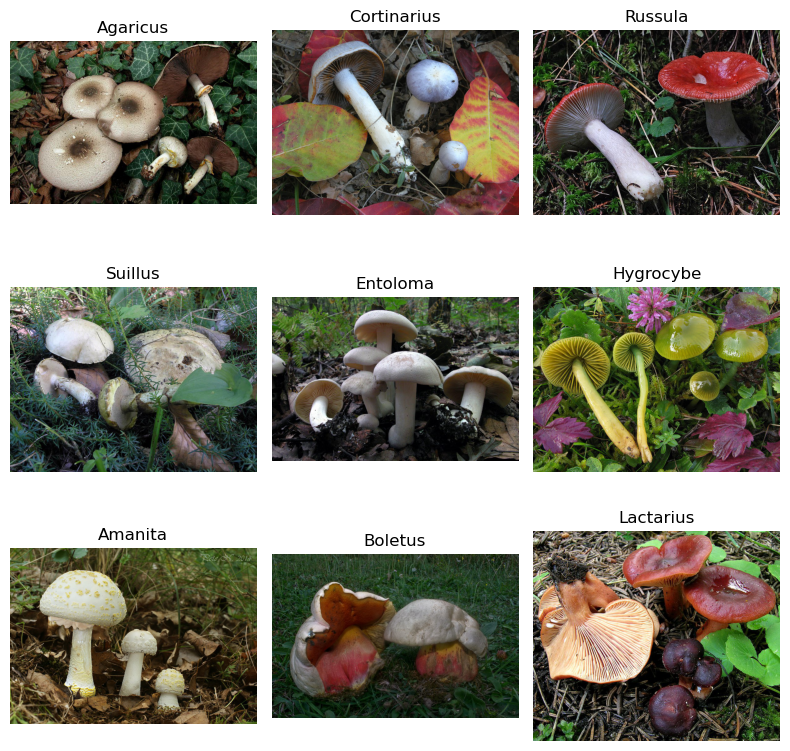

<IPython.core.display.Javascript object>

In [15]:
class_folders = os.listdir(data_dir)
class_folders.remove(".DS_Store")
num_images_per_class = 1
images_dict = {}
images_dict["img_path"] = []
images_dict["img_height"] = []
images_dict["img_width"] = []
images_dict["img_num_pixels"] = []
images_dict["img_num_channels"] = []
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, class_name in enumerate(class_folders):
    class_path = os.path.join(data_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(".jpg")]
    for image in images:
        img = Image.open(class_path + "/" + image)
        width, height = img.size
        img_num_pixels = width * height
        num_channels = img.mode
        images_dict["img_path"].append(image)
        images_dict["img_height"].append(height)
        images_dict["img_width"].append(width)
        images_dict["img_num_pixels"].append(img_num_pixels)
        images_dict["img_num_channels"].append(num_channels)
    if images:
        random_image = random.choice(images)
        image_path = os.path.join(class_path, random_image)
        img = Image.open(image_path)
        axes[i // 3, i % 3].imshow(img)
        axes[i // 3, i % 3].set_title(class_name)
        axes[i // 3, i % 3].axis("off")

plt.tight_layout()
plt.show()

The dictionary is transformed into a dataframe (see bellow).

In [16]:
images_df = pd.DataFrame(images_dict)
images_df.head()

,img_path,img_height,img_width,img_num_pixels,img_num_channels
0,251_J9uSJkkBULQ.jpg,531,800,424800,RGB
1,357__w_XUQZMZEw.jpg,600,800,480000,RGB
2,374_Xap1L15Z8BM.jpg,600,777,466200,RGB
3,442_bdfUNhioT1A.jpg,600,800,480000,RGB
4,092_YzaMvFvqkiM.jpg,575,800,460000,RGB


<IPython.core.display.Javascript object>

In [17]:
images_df.describe()

,img_height,img_width,img_num_pixels
count,6714.000000,6714.000000,6.714000e+03
mean,579.812332,796.176795,4.720923e+05
std,100.118028,132.803124,1.647286e+05
min,152.000000,259.000000,5.022000e+04
25%,533.000000,800.000000,4.224000e+05
50%,580.000000,800.000000,4.456000e+05
75%,600.000000,800.000000,4.800000e+05
max,1024.000000,1280.000000,1.303552e+06


<IPython.core.display.Javascript object>

In [20]:
for column, values in images_df.iloc[:, 1:4].items():
    stat, p = stats.shapiro(values)
    print(f"{column}")
    print(f"Shapiro Wilk test statistics: {stat}")
    print(f"p-value: {p}")
    if p > 0.05:
        print(
            "The data appears to be normally distributed (fail to reject null hypothesis)."
        )
    else:
        print(
            "The data does not appear to be normally distributed (reject null hypothesis)."
        )
    print("")

img_height
Shapiro Wilk test statistics: 0.859581470489502
p-value: 0.0
The data does not appear to be normally distributed (reject null hypothesis).

img_width
Shapiro Wilk test statistics: 0.7487140893936157
p-value: 0.0
The data does not appear to be normally distributed (reject null hypothesis).

img_num_pixels
Shapiro Wilk test statistics: 0.7264012098312378
p-value: 0.0
The data does not appear to be normally distributed (reject null hypothesis).



<IPython.core.display.Javascript object>

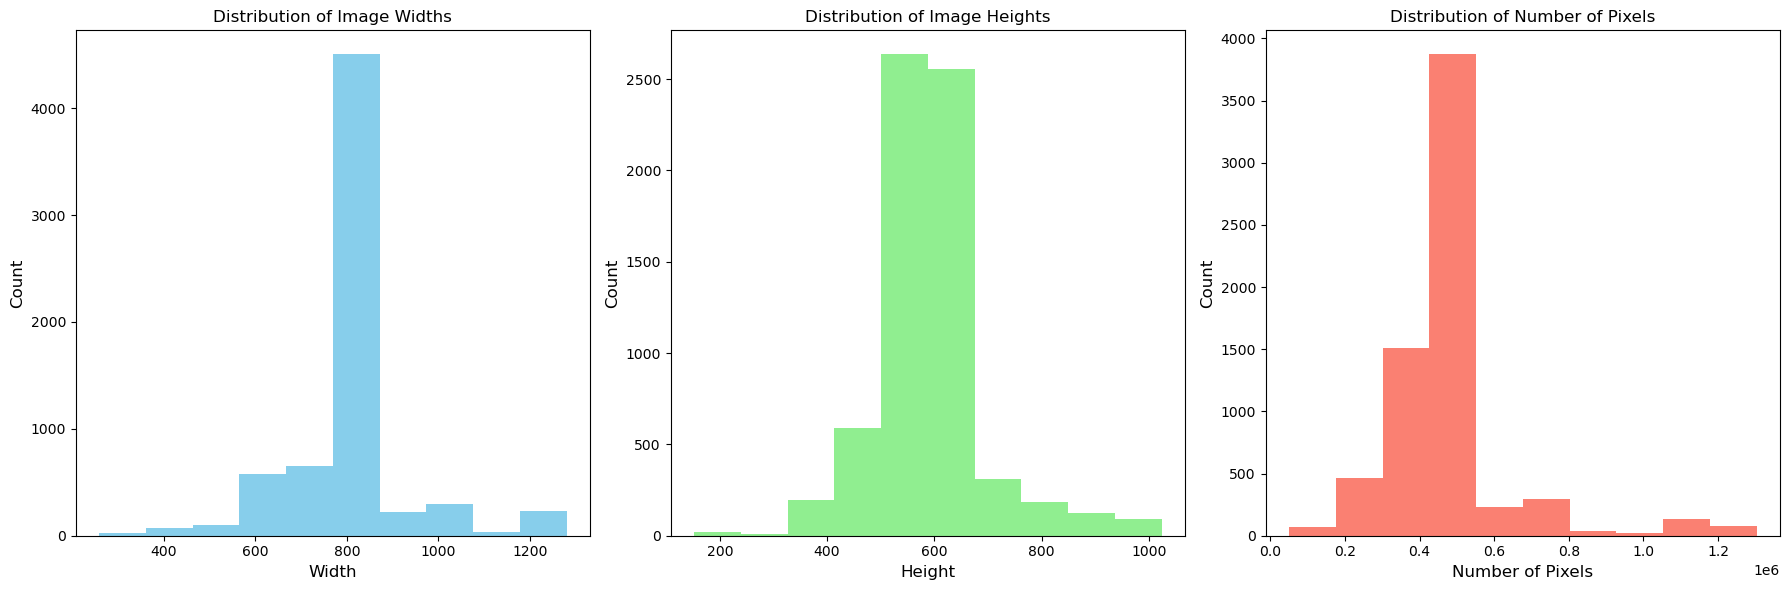

<IPython.core.display.Javascript object>

In [21]:

images_df['num_pixels'] = images_df['img_width'] * images_df['img_height']

# Create a 1x3 subplot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot distribution of image widths
images_df['img_width'].plot(kind='hist', ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Image Widths', fontsize=12)
axes[0].set_xlabel('Width', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Plot distribution of image heights
images_df['img_height'].plot(kind='hist', ax=axes[1], color='lightgreen')
axes[1].set_title('Distribution of Image Heights', fontsize=12)
axes[1].set_xlabel('Height', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)

# Plot distribution of number of pixels
images_df['num_pixels'].plot(kind='hist', ax=axes[2], color='salmon')
axes[2].set_title('Distribution of Number of Pixels', fontsize=12)
axes[2].set_xlabel('Number of Pixels', fontsize=12)
axes[2].set_ylabel('Count', fontsize=12)

# Adjust layout for better display
plt.tight_layout()
plt.show()


In [17]:
images_df["img_num_channels"].value_counts()

RGB    6712
L         2
Name: img_num_channels, dtype: int64

It can be observed from the examination of the descriptive statistics that images in the mushroom dataset are not of the same size. As it seen from the results of the Shapiro Wilk test, widths, hights, and numbers of pixels are not normally distrubuted (p values are lower than 0.05). Their heights and width vary from the smallest (152 height and 256 width respectively) and largest (1024 heigth and 1280 width respectively). The average height and width are 579 and 796 respectively. The average size of pixels is 470000. The majority of images are colourful (RGB channel), only two images are greyscale.





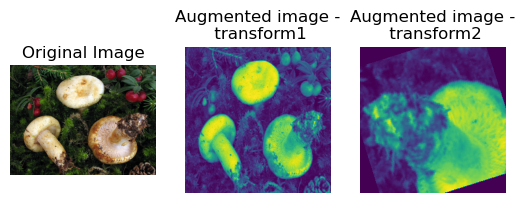

In [18]:
random_image = random.choice(images)
example_image = Image.open(class_path+'/'+random_image)

augmented_image1 = transform1(example_image).numpy()[0]
augmented_image2 = transform2(example_image).numpy()[0]

fig, axs = plt.subplots(1, 3)

axs[0].imshow(example_image)
axs[0].set_axis_off()
axs[0].set_title("Original Image")

axs[1].imshow(augmented_image1)
axs[1].set_axis_off()
axs[1].set_title("Augmented image -\n transform1")

axs[2].imshow(augmented_image2)
axs[2].set_axis_off()
axs[2].set_title("Augmented image -\n transform2")
plt.show();

#### Plotting the distribution of mushroom classes

In [19]:
classes = [output_label(label) for _, label in dataset1]
class_count = Counter(classes)
class_count = pd.Series(class_count).sort_values(ascending=False)

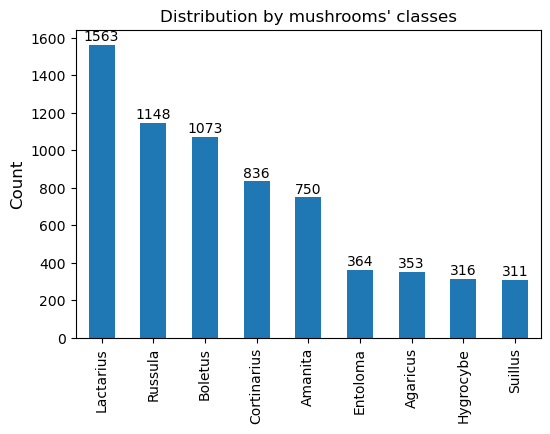

In [20]:
ax = class_count.plot(kind="bar", figsize=(6,4))
plt.title("Distribution by mushrooms' classes", fontsize=12)
plt.ylabel("Count", fontsize=12)

for i, count in enumerate(class_count):
    ax.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

plt.show();

The distribution of categorical variable 'classes' with labels for names of mushroom classes as its values is plotted with the barplot (images of each class are counted with the Counter module). It can be observed that the variable is imbalanced with such classes as Lactarius, Russula, and Boletus having more than 1000 images and such classes as Entoloma, Agaricus, Hygrocebe, and Suillus having less than 400 images. 

#### Removing images higher than a certain threshhold

As it was observed that large images cannot be processed during the training, validation ir testing stages, it was decided to remove them from the mushroom dataset based on the arbitrarily set threshhold.

In [21]:
threshold_width = 1000
threshold_height = 800

In [22]:
input_dir = '/Users/user/PycharmProjects/ComputerVision/Mushrooms/'

In [25]:
output_dir = input_dir+'Mushrooms_filtered'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [26]:
for i, class_name in enumerate(class_folders):
    class_path = os.path.join(data_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith('.jpg')]
    for image in images:
        image_path = os.path.join(class_path, image)
        img = Image.open(image_path)

        width, height = img.size
        if width > threshold_width or height > threshold_height:
            pass
        else:
            class_dir = os.path.join(output_dir,class_name)
            if not os.path.exists(class_dir):
                os.makedirs(class_dir)
            output_path = os.path.join(class_dir, image)
            img.save(output_path)
print("Image filtering complete.")

Image filtering complete.


In [27]:
dataset3 = ImageFolder(root=output_dir, transform=transform1)

In [28]:
dataset4 = ImageFolder(root=output_dir, transform=transform2)

In [29]:
len(dataset3)

6238

## 2. Modelling

In this part the process and results of transfer learning for mushroom classification are presented. The pretained models of image classification (resnet18, resnet50, and resnet150) are used for building models which would be able to correctly predict classes of mushrooms based on images of mushrooms.

### Splitting the dataset into train, validation and test datasets

By the use of the function 'split_datasets()' the dataset is randomly split into train (60 percent), validation (20 percent, and test (20 percent) datasets. 

As the mushroom dataset is imbalanced (see the distribution of the mushroom classes in the exploratory analysis part), the function 'set_weights() is created which counts numbers of mushrooms in each class, calculates weights of each mushroom class based on these numbers, and multiplies each element of the image tensor in the train dataset by these class weights (be the use of the WeightedRandomSampler function). This function is only applied to the train dataset, as validation and test datasets are used for assessment and predictions.

In [31]:
def set_weights(dataset):
    train_classes = [label for _, label in dataset]
    class_count = Counter(train_classes)
    class_weights = torch.Tensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
    sample_weights = [0] * len(dataset)
    dataset.shuffle()
    for idx, (image, label) in enumerate(dataset):
        class_weight = class_weights[label]
        sample_weights[idx] = class_weight

    sampler = WeightedRandomSampler(weights=sample_weights,
                                        num_samples = len(dataset), replacement=True)
    return sampler

In [32]:
batch_size = 32

In [33]:
def split_datasets(dataset):
    train_size = int(0.6 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return train_dataset, val_dataset, test_dataset

In [34]:
train_dataset3, val_dataset3, test_dataset3 = split_datasets(dataset3)

In [35]:
sampler3 = set_weights(train_dataset3)

In [36]:
train_dataset4, val_dataset4, test_dataset4 = split_datasets(dataset4)

In [37]:
sampler4 = set_weights(train_dataset4)

### Creating classes for transfer learning based on pre-trained models

The ResnetLightening class is created as a Pytorch Lightning module. This class initiates a pretrained model (which is loaded from the 'PyTorch/Vision' model-zoo using 'torch.hub.load') and replaces fully connected resnet model layer with a new one having num_classes output features (for mushroom class labels) as well as multiclass 'Accuracy' metrics for use in tracking the accuracy during training and validation (by the use of torchmetrics library). 

It also contains methods which are commonly included into Pytorch Lightning modules used for deep learning: 
- forward (to pass the input x through the ResNet model and return the output), 
- training_step (to compute the predicted output using the forward pass and calculate the cross-entropy loss), 
- validation_step and test_step (to compute the cross-entropy loss and accuracy for the given batch of data and log these metrics),
- predict_step (to make predictions), 
- shared_eval_step (to calculate loss and accuracy by taking a batch of input data and labels, computing predictions, and returning both loss and accuracy),
- configure_optimizers (to select optimizers), 
- train_dataloader, val_dataloader, test_dataloader (to return data loaders for the training, validation, and test datasets).

In order to instantiate this module with different parameters, the function 'create_lightning_module' is created with arguments such as num_classes, opt, learning_rate, arguments for train, validation and test datasets as well as sampler which could vary for different models.

In [46]:
def create_lightning_module(model, num_classes, opt, learning_rate, 
                            train_dataset, val_dataset, test_dataset, 
                           sampler):
    class ResnetLightening(pl.LightningModule):
        def __init__(self, num_classes):
            super().__init__()
            self.resnet = torch.hub.load('pytorch/vision', model, pretrained=True)
            for param in self.resnet.parameters():
                param.requires_grad = False
            num_features = self.resnet.fc.in_features
            self.resnet.fc = nn.Sequential(dropout, num_features, num_classes)
            self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
         
        def forward(self, x):
            return self.resnet(x)
        
        def unfreeze(self):
            for param in self.resnet.parameters():
                param.requires_grad = True

        def training_step(self, batch, batch_idx):
            x, y = batch
            y_hat = self.forward(x)
            loss = F.cross_entropy(y_hat, y)
            self.accuracy(y_hat, y)
            #self.log('train_acc_step', self.accuracy)
            mtrcs = {"val_acc": acc, "val_loss": loss}
            self.log_dict(mtrcs)
            return metrics

        def validation_step(self, batch, batch_idx):
            loss, acc = self._shared_eval_step(batch, batch_idx)
            mtrcs = {"val_acc": acc, "val_loss": loss}
            self.log_dict(mtrcs)
            return metrics

        def test_step(self, batch, batch_idx):
            loss, acc = self._shared_eval_step(batch, batch_idx)
            mtrcs = {"test_acc": acc, "test_loss": loss}
            self.log_dict(mtrcs)
            return metrics
        
        def predict_step(self, batch, batch_idx):
            x, y = batch
            y_hat = self.forward(x)
            return nn.softmax(y_hat)
           
        def _shared_eval_step(self, batch, batch_idx):
            x, y = batch
            y_hat = self.forward(x)
            loss = F.cross_entropy(y_hat, y)
            acc = self.accuracy(y_hat, y)
            return loss, acc

        def configure_optimizers(self):
            if opt == 'Adam':
                optimizer = optim.Adam(self.resnet.parameters(), lr=learning_rate)
            elif opt == 'SGD':
                optimizer = optim.SGD(self.resnet.parameters(), lr=learning_rate)
            return optimizer
    
        def train_dataloader(self):
            return DataLoader(train_dataset, batch_size=batch_size, 
                              shuffle=True, num_workers=6, sampler=sampler)

        def val_dataloader(self):
            return DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=6)

        def test_dataloader(self):
            return DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=6)

    return ResnetLightening(num_classes = num_classes)
    

### Creating instances of the classes for transfer learning

Models with different parameters are instatiated on the RestnetLightening class defined above. The first three models use different resnet models (resnet18, renet50 and resnet152) but the same learning rate (0.001), the Adam optimizer, and the same transformations of the train, validation and test datasets (transform1).

The next three models use the pretrained model resnet152 with the highest number of layers but one of them uses SGD optimizer instead of the Adam optimizer, another one uses learning rate 0.01 instead of 0.001, and the last one uses different transformation of the datasets (transform2).

In [47]:
model18 = create_lightning_module(model = 'resnet18', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.001, 
                                 train_dataset = train_dataset3,
                                 val_dataset = val_dataset3,
                                 test_dataset = test_dataset3,
                                 sampler = sampler3)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [48]:
model50 = create_lightning_module(model = 'resnet50', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.001, 
                                 train_dataset = train_dataset3,
                                 val_dataset = val_dataset3,
                                 test_dataset = test_dataset3,
                                 sampler = sampler3)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [49]:
model152 = create_lightning_module(model = 'resnet152', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.001, 
                                 train_dataset = train_dataset3,
                                 val_dataset = val_dataset3,
                                 test_dataset = test_dataset3,
                                 sampler = sampler3)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [50]:
model152_SGD = create_lightning_module(model = 'resnet152', 
            num_classes = 9, opt = 'SGD', learning_rate = 0.001, 
                                 train_dataset = train_dataset3,
                                 val_dataset = val_dataset3,
                                 test_dataset = test_dataset3,
                                 sampler = sampler3)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [51]:
model152_01 = create_lightning_module(model = 'resnet152', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.01, 
                                 train_dataset = train_dataset3,
                                 val_dataset = val_dataset3,
                                 test_dataset = test_dataset3,
                                 sampler = sampler3)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [52]:
model152_aug = create_lightning_module(model = 'resnet152', 
            num_classes = 9, opt = 'AdamW', learning_rate = 0.001, 
                                 train_dataset = train_dataset4,
                                 val_dataset = val_dataset4,
                                 test_dataset = test_dataset4,
                                 sampler = sampler4)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [53]:
model_list = [model18, model50, model152, model152_SGD, model152_01, model152_aug]
model_name_list = ['model18', 'model50', 'model152', 'model152_SGD', 'model152_01', 'model152_aug']

### Summarizing model parameters

Summaries of the parameters of the models are presented bellow.

In [54]:
for model, model_name in zip(model_list, model_name_list):
    print(f'{model_name}')
    print(f'{summary(model, (3, 256, 256))}')
    print('')


model18
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

None

model152_01
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

### Assigning the models to the GPU of the Mac computer

The models were trained on the Mac computer with the M2 processor which 10 GPU cores, thus, the GPU use was assigned to each model.

In [55]:
device = torch.device("mps")
for model in model_list:
    model.to(device)


### Training the models

The metrics of each models as well as time used for training and prediction were recorder into a dictionary which will be later transformed into a pandas dataframe in order to compare scores of various models. Initially, the structure of the dictionary was set that was latter filled with the appended data from the steps of training, model assessment and predictions. 

In [66]:
metrics_df = {}
metrics_df["model_name"] = []
metrics_df["train_time"] = []
metrics_df["prediction_time"]=[]
metrics_df["val_accuracy"]=[]
metrics_df["val_loss"]=[]
metrics_df["test_accuracy"]=[]
metrics_df["test_loss"]=[]
trainer_list = []

The models which were included into a separate list were trained with the Pytorch Lighntning trainer and, after the training process ended, were got saved into a local file. 

In [67]:
for model, model_name in zip(model_list, model_name_list):
    start_time = time.time()
    trainer = pl.Trainer(max_epochs = 10)
    trainer.fit(model)
    trainer_list.append(trainer)

    end_time = time.time()
    exec_time = end_time - start_time
    print('')
    print(f'{model_name}')
    print(f'Execution time: {exec_time}')
    metrics_df["model_name"].append(model_name)
    metrics_df["train_time"].append(exec_time)
    
    checkpoint_path = f'mushroom_classifier_naujas2_{model_name}.ckpt'
    trainer.save_checkpoint(checkpoint_path)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type               | Params
------------------------------------------------
0 | resnet   | ResNet             | 11.2 M
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
4.6 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



model18
Execution time: 881.8004369735718



  | Name     | Type               | Params
------------------------------------------------
0 | resnet   | ResNet             | 23.5 M
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
18.4 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.106    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.



model50
Execution time: 1185.4063658714294


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type               | Params
------------------------------------------------
0 | resnet   | ResNet             | 58.2 M
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
18.4 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.649   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.



model152
Execution time: 1822.014242887497


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type               | Params
------------------------------------------------
0 | resnet   | ResNet             | 58.2 M
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
18.4 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.649   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.



model152_SGD
Execution time: 1846.007171869278


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type               | Params
------------------------------------------------
0 | resnet   | ResNet             | 58.2 M
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
18.4 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.649   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.



model152_01
Execution time: 1849.0416440963745


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type               | Params
------------------------------------------------
0 | resnet   | ResNet             | 58.2 M
1 | accuracy | MulticlassAccuracy | 0     
------------------------------------------------
18.4 K    Trainable params
58.1 M    Non-trainable params
58.2 M    Total params
232.649   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.



model152_aug
Execution time: 1853.7106380462646


It can be seen that the training time for various models varied - it took 14 minutes to train the model with the lowest number of layers (resnet18) while for the models with more layers (resnet152) it took 30 minutes to train them.

### Assessing the performance of the models on the validation and test datasets

The model performance was assessed with the functions trainer.validate() (for the validation dataset) and trainer.test() (for the test dataset). The outputs of assessment are presented bellow.

In can be observed that the models perform similarly on the validation data and on the test data. The resnet152 model with the Adam optimizer, learning rate 0.001 and the first combination of transformers (resize, to-tensor and normalize) provides:
- the highest accuracy (0.708) 
- and the lowest loss (0.81) for the validation data;
- the highest accuracy (0.704)
- and the lowest loss (0.87) for the test data.

Thus, this model could be considered as the best classifier among the six classifiers with the different parameters. 


#### Validation dataset:

In [70]:
for trainer, model_name in zip(trainer_list, model_name_list):
    print(f'{model_name}')
    metric = trainer.validate()
    metrics_df['val_accuracy'].append(metric[0]["val_acc"])
    metrics_df['val_loss'].append(metric[0]["val_loss"])
    print('')

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_82/checkpoints/epoch=9-step=1170.ckpt
Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_82/checkpoints/epoch=9-step=1170.ckpt


model18


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.6712108850479126     │
│         val_loss          │    0.9378331303596497     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_83/checkpoints/epoch=9-step=1170.ckpt



model50


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_83/checkpoints/epoch=9-step=1170.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.692862868309021     │
│         val_loss          │    0.8789471387863159     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_84/checkpoints/epoch=9-step=1170.ckpt



model152


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_84/checkpoints/epoch=9-step=1170.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7080994248390198     │
│         val_loss          │    0.8108006119728088     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_85/checkpoints/epoch=9-step=1170.ckpt



model152_SGD


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_85/checkpoints/epoch=9-step=1170.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.5477145314216614     │
│         val_loss          │    1.5189884901046753     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_86/checkpoints/epoch=9-step=1170.ckpt



model152_01


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_86/checkpoints/epoch=9-step=1170.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.6343223452568054     │
│         val_loss          │    1.6282902956008911     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_87/checkpoints/epoch=9-step=1170.ckpt



model152_aug


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_87/checkpoints/epoch=9-step=1170.ckpt


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.6118685007095337     │
│         val_loss          │    1.1241047382354736     │
└───────────────────────────┴───────────────────────────┘

#### Test dataset:

In [71]:
for trainer, model_name in zip(trainer_list, model_name_list):
    print(f'{model_name}')
    metric = trainer.test()
    metrics_df['test_accuracy'].append(metric[0]["test_acc"])
    metrics_df['test_loss'].append(metric[0]["test_loss"])
    print('')

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_82/checkpoints/epoch=9-step=1170.ckpt
Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_82/checkpoints/epoch=9-step=1170.ckpt


model18


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6525220274925232     │
│         test_loss         │    1.0117230415344238     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_83/checkpoints/epoch=9-step=1170.ckpt



model50


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_83/checkpoints/epoch=9-step=1170.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6845476627349854     │
│         test_loss         │    0.9269766211509705     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_84/checkpoints/epoch=9-step=1170.ckpt



model152


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_84/checkpoints/epoch=9-step=1170.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7045636773109436     │
│         test_loss         │    0.8712285161018372     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_85/checkpoints/epoch=9-step=1170.ckpt



model152_SGD


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_85/checkpoints/epoch=9-step=1170.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5252201557159424     │
│         test_loss         │    1.5445014238357544     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_86/checkpoints/epoch=9-step=1170.ckpt



model152_01


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_86/checkpoints/epoch=9-step=1170.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6253002285957336     │
│         test_loss         │     1.800525188446045     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_87/checkpoints/epoch=9-step=1170.ckpt



model152_aug


Loaded model weights from the checkpoint at /Users/user/PycharmProjects/ComputerVision/lightning_logs/version_87/checkpoints/epoch=9-step=1170.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6541233062744141     │
│         test_loss         │     1.018893837928772     │
└───────────────────────────┴───────────────────────────┘

The dictionary with the added validation and test metrics was saved to the local file.

In [79]:
with open('metrics_df.pkl','wb') as fp:
    pickle.dump(metrics_df, fp)
    print('The dictionary saved to a file.')

The dictionary saved to a file.


### Loading models from a local directory and generating predictions on them

The next step was to generate predictions based on the trained models, to get and vizualize more specific metrics.

First, metrics dictionary and trained models were loaded from the local files. The models and their names were saved into separate lists. 

In [56]:
with open('metrics_df.pkl','rb') as f:
    metrics_df = pickle.load(f)

In [57]:
checkpoint_path_list = []
for model_name in model_name_list:
    checkpoint_path = f'mushroom_classifier_naujas2_{model_name}.ckpt'
    checkpoint_path_list.append(checkpoint_path)
 

In [61]:
model18_load = create_lightning_module(model = 'resnet18', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.001, 
                                 train_dataset = train_dataset3,
                                 val_dataset = val_dataset3,
                                 test_dataset = test_dataset3,
                                 sampler = sampler3).load_from_checkpoint(checkpoint_path_list[0], 
                                                                                      num_classes=9)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [62]:
model50_load = create_lightning_module(model = 'resnet50', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.001, 
                                 train_dataset = train_dataset3,
                                 val_dataset = val_dataset3,
                                 test_dataset = test_dataset3,
                                 sampler = sampler3).load_from_checkpoint(checkpoint_path_list[1],
                                                                                       num_classes=9)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [63]:
model152_load = create_lightning_module(model = 'resnet152', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.001, 
                                 train_dataset = train_dataset3,
                                 val_dataset = val_dataset3,
                                 test_dataset = test_dataset3,
                                 sampler = sampler3).load_from_checkpoint(checkpoint_path_list[2],
                                                                                         num_classes=9)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [64]:
model152_SGD_load = create_lightning_module(model = 'resnet152', 
            num_classes = 9, opt = 'SGD', learning_rate = 0.001, 
                                 train_dataset = train_dataset3,
                                 val_dataset = val_dataset3,
                                 test_dataset = test_dataset3,
                                 sampler = sampler3).load_from_checkpoint(checkpoint_path_list[3],
                                                                                        num_classes=9)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [65]:
model152_01_load = create_lightning_module(model = 'resnet152', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.01, 
                                 train_dataset = train_dataset3,
                                 val_dataset = val_dataset3,
                                 test_dataset = test_dataset3,
                                 sampler = sampler3).load_from_checkpoint(checkpoint_path_list[4],
                                                                                        num_classes=9)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [67]:
model152_aug_load = create_lightning_module(model = 'resnet152', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.001, 
                                 train_dataset = train_dataset4,
                                 val_dataset = val_dataset4,
                                 test_dataset = test_dataset4,
                                 sampler = sampler4).load_from_checkpoint(checkpoint_path_list[5],
                                                                                        num_classes=9)

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


In [68]:
load_model_list = [model18_load, model50_load, model152_load, 
                   model152_SGD_load, model152_01_load, model152_aug_load]
load_model_name_list = ['model18_load', 'model50_load', 'model152_load', 
                        'model152_SGD_load', 'model152_01_load', 'model152_aug_load']

### Generating predictions on the models

Predictions were generated on the preprocessed test data (with the first combination of transformers). Tensors of probabilities of classes for each batch of images were generated and the class with the highest probability was chosen for each image; tensors with chosen classes for each image were saved into a list. Also, true labels of classes for this dataset were appended into a separate list.


In [ ]:
device = torch.device("cpu")
for model in load_model_list:
    model.to(device)

In [112]:
predictions_list = []
y_true_list = []
for model, model_name in zip(load_model_list, load_model_name_list):
    predictions_ = []
    y_true_ = []
    start_time= time.time()
    with torch.no_grad():
        for data, labels in DataLoader(test_dataset3, batch_size=32, shuffle=False, num_workers=6):
            y_proba = nn.functional.softmax(model.forward(data), dim=1)
            y_hat = torch.argmax(y_proba, axis=1)
            predictions_.append(y_hat)
            y_true_.append(labels)
    predictions_list.append(predictions_)
    y_true_list.append(y_true_)
    end_time = time.time()
    prediction_time = end_time - start_time
    print(f'{model_name}')
    print(f'Prediction time:{prediction_time}')
    metrics_df["prediction_time"].append(prediction_time)

model18_load
Prediction time:74.78801107406616
model50_load
Prediction time:181.25386905670166
model152_load
Prediction time:364.8382341861725
model152_SGD_load
Prediction time:373.8945746421814
model152_01_load
Prediction time:396.3880681991577
model152_aug_load
Prediction time:381.28051018714905


The tensors for batches were stacked into the single tensor (both for prediction and true label lists).

In [115]:
ytrue_list = []
pred_list = []
for predictions_ in predictions_list:
    predictions = torch.stack(predictions_[:-1]).view(-1)
    pred_list.append(predictions)

for y_true_ in y_true_list:   
    y_true = torch.stack(y_true_[:-1]).view(-1)
    ytrue_list.append(y_true)

### Comparing and visualizing metrics of the models

In this step, comparisons of metrics of sixed trained models are provided. First, the dataframe (created from the metrics dictionary) presents comparative data on accuracy and loss of validation and test datasets, also time used for training and prediction.

In [259]:
metrics_df = pd.DataFrame(metrics_df).set_index('model_name')
metrics_df

,train_time,prediction_time,val_accuracy,val_loss,test_accuracy,test_loss
model_name,,,,,,
model18,881.800437,74.788011,0.671211,0.937833,0.652522,1.011723
model50,1185.406366,181.253869,0.692863,0.878947,0.684548,0.926977
model152,1822.014243,364.838234,0.708099,0.810801,0.704564,0.871229
model152_SGD,1846.007172,373.894575,0.547715,1.518988,0.525220,1.544501
model152_01,1849.041644,396.388068,0.634322,1.628290,0.625300,1.800525
model152_aug,1853.710638,381.280510,0.611869,1.124105,0.654123,1.018894


The classification report presents precision, recall and f1-scores for each class separately as well as average accuracy, precision, recall and f1 scores. 

It can be seen that the class Boletus have the highest prediction scores (f1=0.88 for the resnet152 model).

Lacatarius and Russula classes have high precision scores (0.88 and 0.81), however, very low recall scores (0.51 and 0.53). That means that the model correctly predicts the class when it is present but quite often misses to correctly attribute mushrooms to the class when they actually belong to the class. 

On the other hand, Entoloma, Hygrocybe and Sullus classes have high recall scores (0.81, 0.96 and 0.84) but very low precision scores (0.43, 0.55 and 0.54 respectively), that is, the model is effective at catching most cases of the class among those mushrooms who truly belong to it, however, it may also flag some other mushrooms as belonging to these classes.

In [143]:
for pred, ytrue, model_name in zip(pred_list, ytrue_list, model_name_list):
    print(f'{model_name}')
    classification_report = metrics.classification_report(ytrue, pred)
    print(classification_report)
    print('')

model18
              precision    recall  f1-score   support

           0       0.42      0.72      0.53        79
           1       0.64      0.76      0.69       137
           2       0.91      0.68      0.78       177
           3       0.55      0.55      0.55       150
           4       0.32      0.86      0.47        58
           5       0.78      0.83      0.80        52
           6       0.82      0.47      0.60       289
           7       0.70      0.59      0.64       249
           8       0.51      0.72      0.59        57

    accuracy                           0.63      1248
   macro avg       0.63      0.69      0.63      1248
weighted avg       0.69      0.63      0.64      1248


model50
              precision    recall  f1-score   support

           0       0.53      0.72      0.61        79
           1       0.71      0.82      0.76       137
           2       0.91      0.85      0.88       177
           3       0.83      0.39      0.53       150
       

The confusion matrixes for the models are presented in teh heatmaps bellow. 

In [144]:
conf_mat_list = []
for pred, ytrue in zip(pred_list, ytrue_list):
    conf_mat = confusion_matrix(ytrue, pred)
    conf_mat_list.append(conf_mat)


In [145]:
def plot_confusion_matrix(conf_matrix, figsize, model_name):
    plt.figure(figsize=figsize)
    sns.heatmap(pd.DataFrame(np.round(conf_matrix, 2)), annot=True, fmt='g',  
                xticklabels=label_names, yticklabels=label_names)
    plt.title (f"Confusion matrix of the classifier trained on {model_name}")
    plt.show();

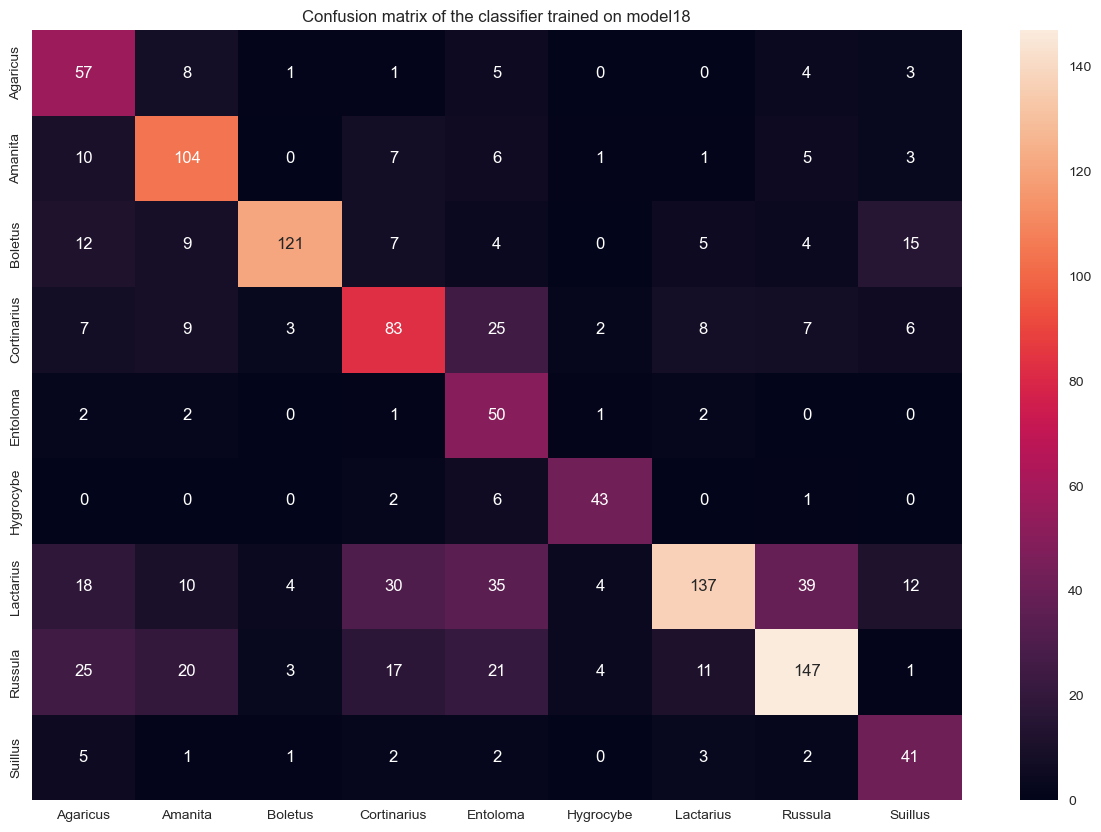

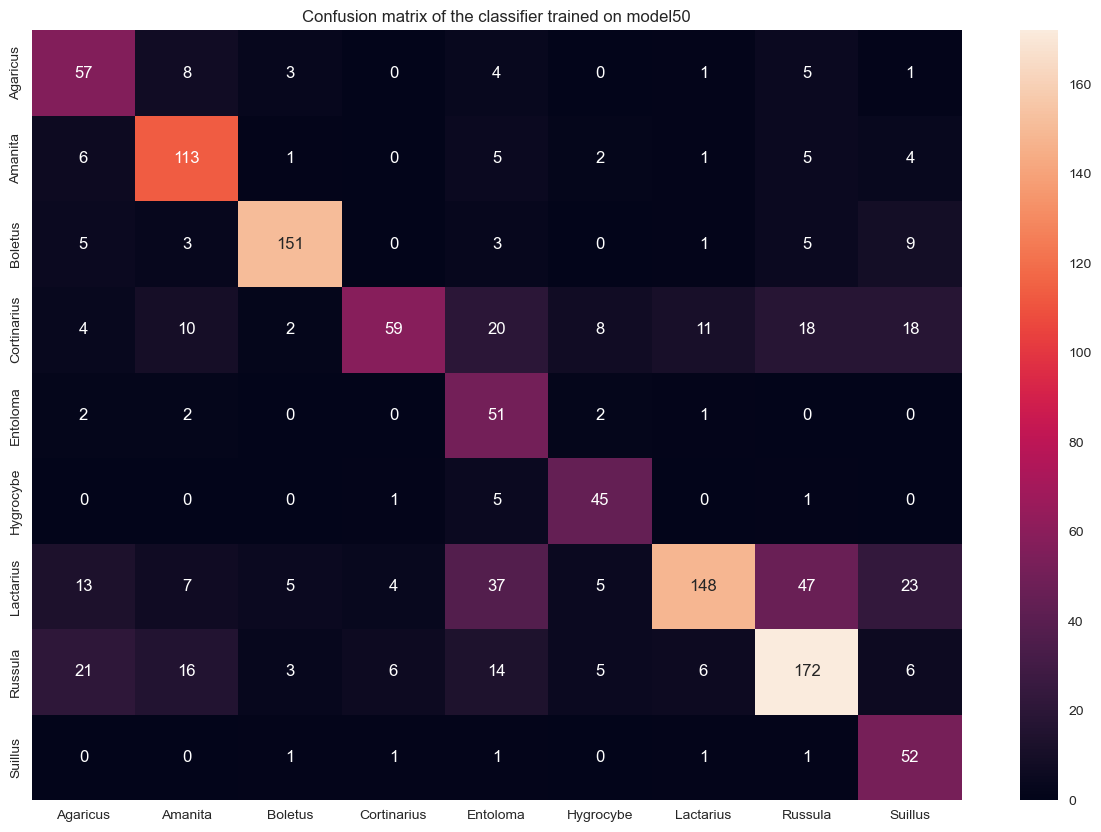

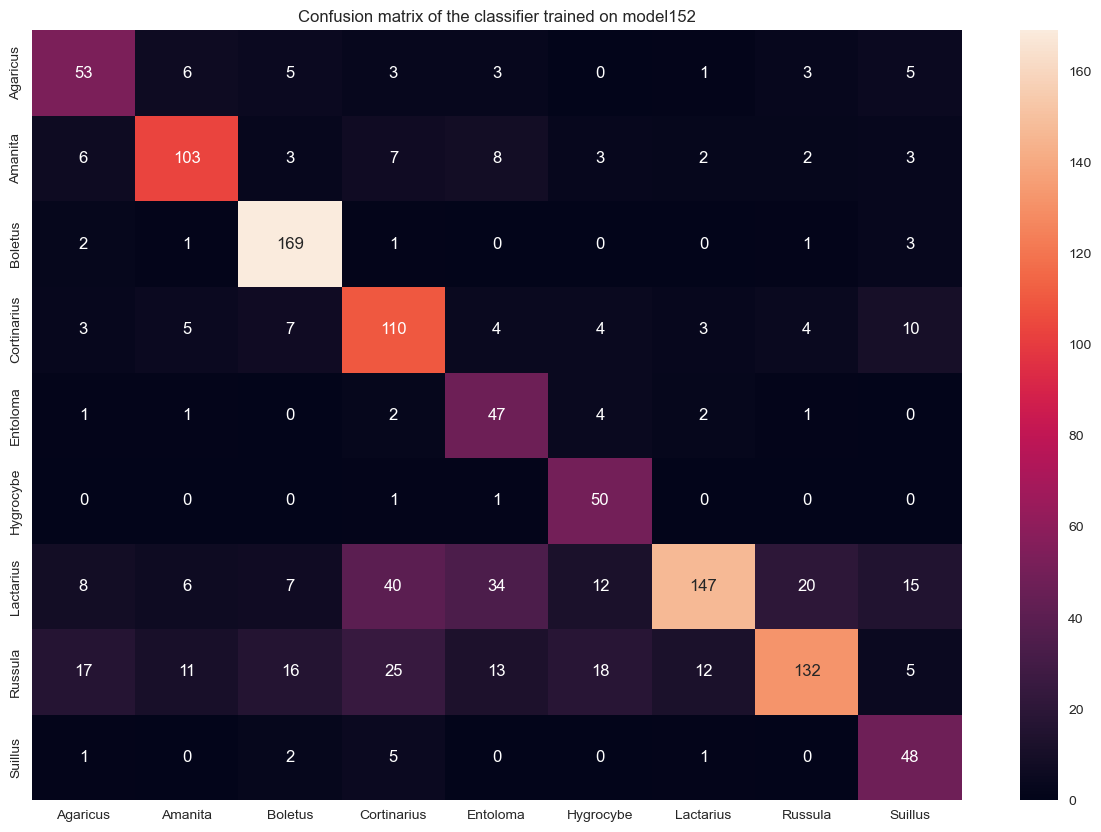

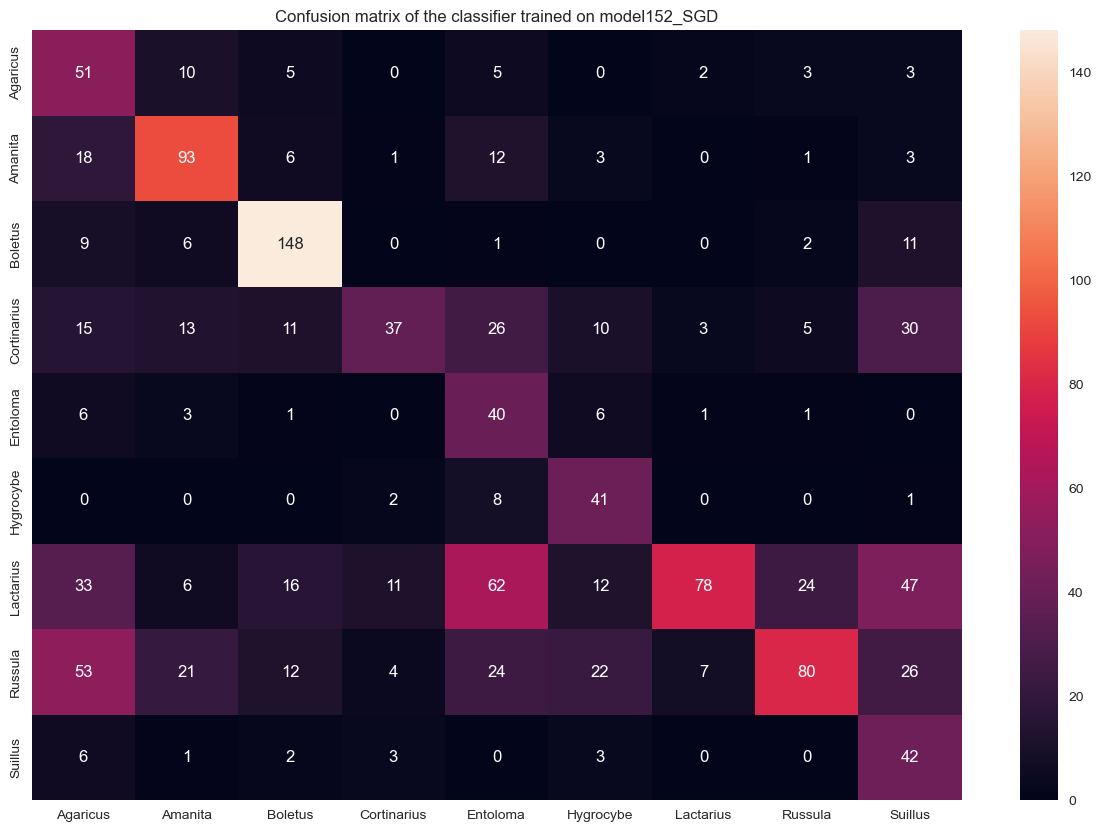

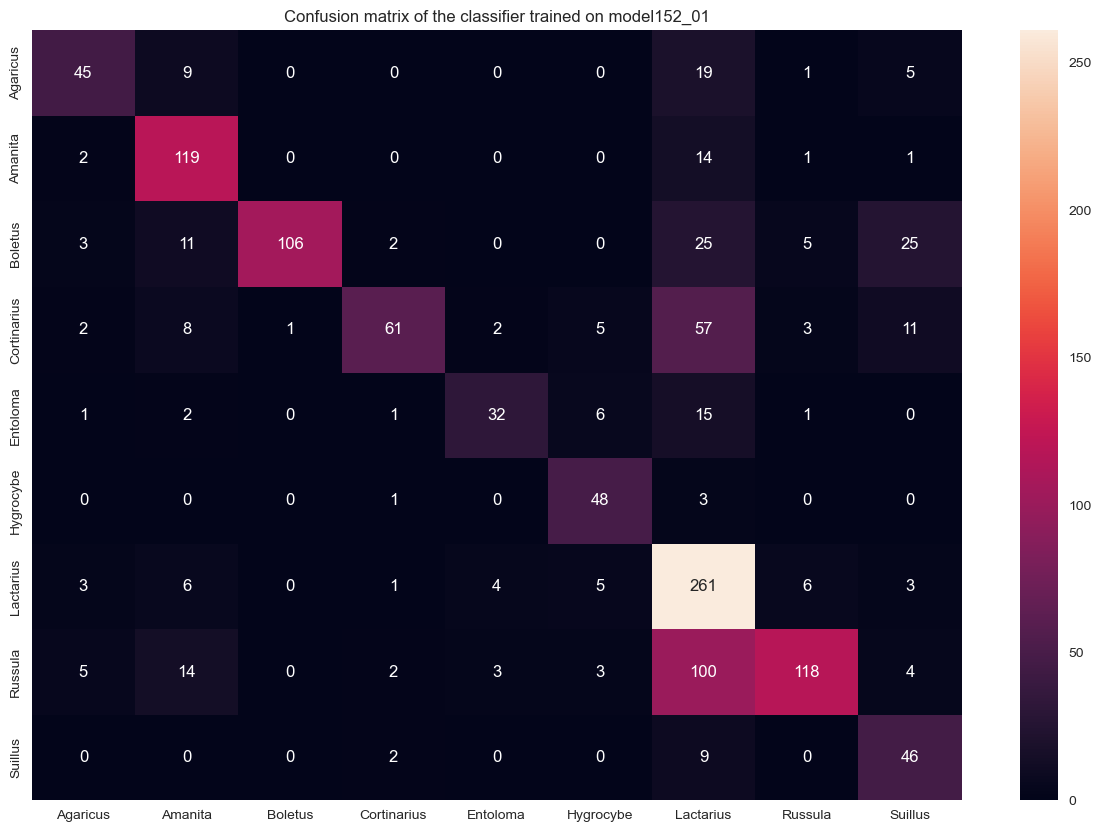

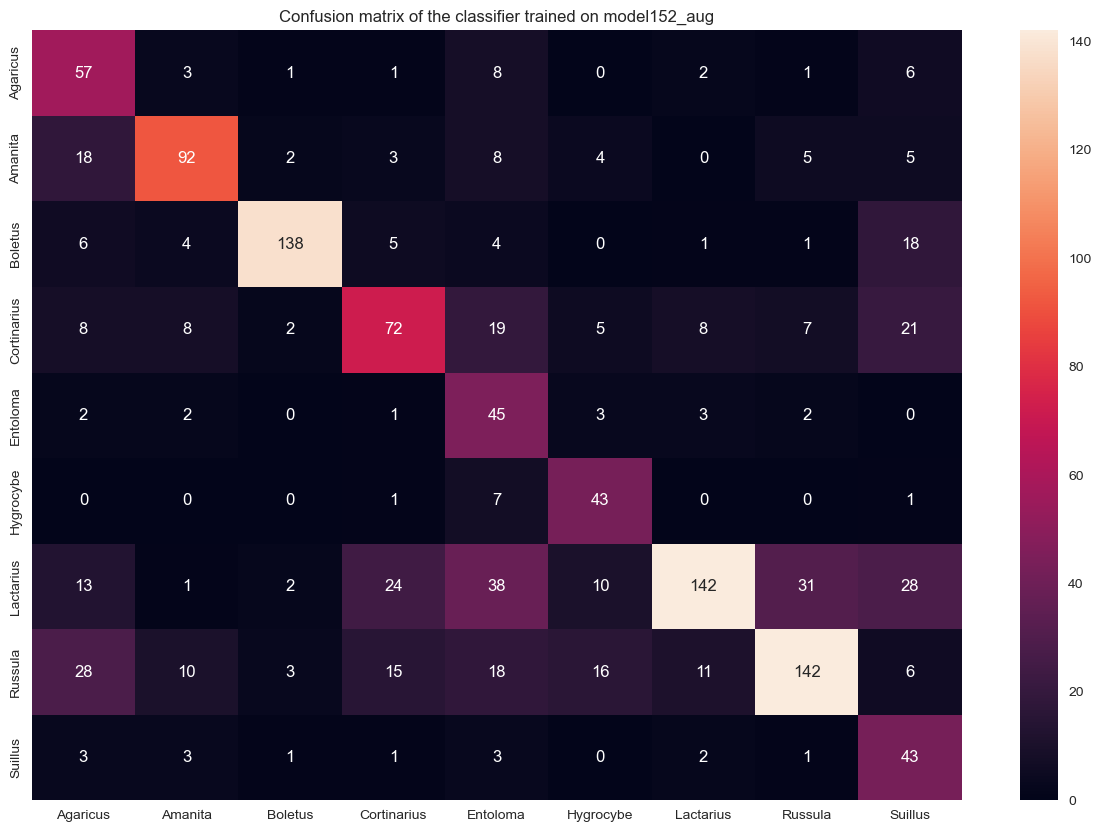

In [146]:
for conf_mat, model_name in zip(conf_mat_list, model_name_list):
    plot_confusion_matrix(conf_mat, (15, 10), model_name)

From the confusion matrixes it can be observed, that, for example, the resnet152 model sometimes mistakenly identifies Lactarius when the class is actually Cortinarius or Entoloma  (40 and 34 mistakes respectively). However, when the mushroom class is actually Lactarius the model does not identify the mushroom as Cortinarius or Entoloma but sometimes treats it as Russula (12 mistakes of this kind).

### Using the mushroom classifier to predict classes of mushroom images

Finally, the best performing classifier (resnet152) was chosen for the use of mushroom prediction on the new mushroom images. Photos of mushroom images were made and saved into a separate folder. The images were resized to the size 800x600 in order to avoid image truncation errors (see bellow). Resized images were saved to a new folder.

In [149]:
def resize_image(input_path, output_path, new_width, new_height):
    try:
        with Image.open(input_path) as img:
            img = img.resize((new_width, new_height), Image.ANTIALIAS)
            img.save(output_path)
        return True, "Image resized successfully!"
    except Exception as e:
        return False, str(e)



In [191]:
input_dir = '/Users/user/PycharmProjects/ComputerVision/Mushrooms/Mushrooms_uploaded'
output_dir = '/Users/user/PycharmProjects/ComputerVision/Mushrooms/Mushrooms_resized'


In [151]:
new_width = 800 
new_height = 600 
images = [f for f in os.listdir(input_dir) if f.lower().endswith('.jpg')]
for image in images:
    input_image_path = os.path.join(input_dir, image)
    output_image_path = os.path.join(output_dir, image)
    img = Image.open(input_image_path)
    success, message = resize_image(input_image_path, output_image_path, new_width, new_height)
    if success:
        print(message)
    else:
        print("Error:", message)


Image resized successfully!
Image resized successfully!
Image resized successfully!
Image resized successfully!


The function 'make_predicions' was created. The function with the image path as an argument opens an image from the path, preprocesses it, loads the trained model from the checkpoint path, and provides prediction of the image class based on this model. The output of prediction is transformed into the tensor of probabilities for each class and then the class with the highest probability is selected. 

In [238]:
def make_predictions(image_path):
    
    img = Image.open(image_path)
    
    preprocess = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
  
    img = preprocess(img)
    img = img.unsqueeze(0)
    
    checkpoint_path = f'mushroom_classifier_naujas2_{model_name}.ckpt'
    
    model = create_lightning_module(model = 'resnet152', 
            num_classes = 9, opt = 'Adam', learning_rate = 0.001, 
                                 train_dataset = train_dataset3,
                                 val_dataset = val_dataset3,
                                 test_dataset = test_dataset3,
                                 sampler = sampler3).load_from_checkpoint(checkpoint_path,
                                                                                         num_classes=9)
    with torch.no_grad():
        outputs = model(img)
    predictions = F.softmax(outputs[0], dim=0)
    max_index = torch.argmax(predictions)
    labeled_predictions = output_label(max_index)
    
    return labeled_predictions
  

The function was run on the four uploaded images of mushrooms. The mushrooms and their classifications are presented bellow. 

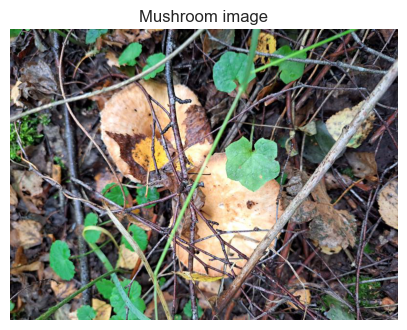

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


The mushroom belongs to the class: Cortinarius


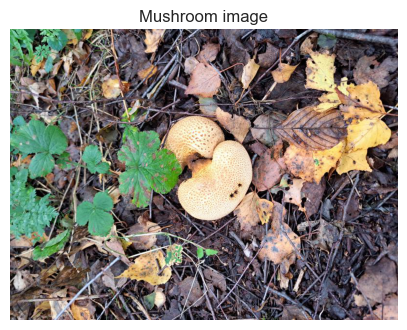

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


The mushroom belongs to the class: Lactarius


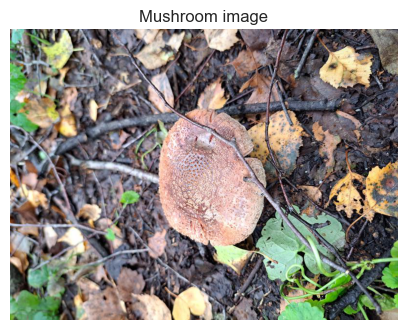

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


The mushroom belongs to the class: Cortinarius


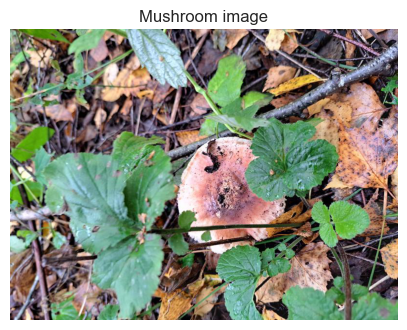

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main
Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_main


The mushroom belongs to the class: Cortinarius


In [250]:
images = [f for f in os.listdir(output_dir) if f.lower().endswith('.jpg')]
for image in images:
    image_path = os.path.join(output_dir, image)
    example_image = Image.open(image_path)
    plt.figure(figsize=(5, 4))
    plt.axis('off')
    plt.imshow(example_image)
    plt.title("Mushroom image")
    plt.show();

    pred = make_predictions(image_path)
    print(f'The mushroom belongs to the class: {pred}')


## Conclusions

The project provides the exploratory analysis and training of deep learning models able to classify images of mushrooms to nine mushroom classes: Agaricus, Amanita, Boletus, Cortinarius, Entoloma, Hygrocybe, Lactarius, Russula, Suillus. The classifiers are trained on the basis of the pretrained models resnet18, resnet50 and resnet152 with various parameters (optimizer, learning rate, combinations of transformers). 

The following conclusions can be made:
- the pretrained model resnet152 (with 152 convolution layers) with the Adam optimizer, learning rate 0.001 and the first combination of transformers (resize, to-tensor and normalize) could be considered as the best classifier out of six tested models because it provides:
  - the highest accuracy (0.708)
  - and the lowest loss (0.81) for the validation data;
  - the highest accuracy (0.704)
  - and the lowest loss (0.87) for the test data.
- the changes of learning rate from 0.001 to 0.01, from the Adam otimizer to the SGD optimizer, from more convolution layers to less convolution layers, from less transformations to more transformations of images resulted in less accurate predictions.
 - the best classifier (resnet152 model) is able to most correctly predict the Boletus class (the f1 score is the highest among all of the classes (0.88)).
 - the model correctly predicts the Lacatarius and Russula classes when the mushrooms actually belong to them but quite often misses to correctly attribute other mushrooms of these classes (high precision scores (0.88 and 0.81), however, very low recall scores (0.51 and 0.53)). 
 - the model is effective at catching most cases of the Entoloma, Hygrocybe and Sullus classes  among those mushrooms who truly belong to them, however, it may also flag some other mushrooms as belonging to these classes (high recall scores (0.81, 0.96 and 0.84) but very low precision scores (0.43, 0.55 and 0.54 respectively).
 
 #### Limitations and suggestions for improvement:
 
 ##### Limitations: 
 1. The solution was not found how to increase the train dataset with augmented images (with various transformations such as blurring, rotating, etc.)
 2. The models were trained with 10 epochs but the prediction scores could have been be improved if models were trained with higher numbers of epochs.
 3. It was not tested how models could perform if different numbers of batch sizes could be chosen.
 
 ##### Suggestions for improvement:
 1. To improve the prediction power of mushroom image classifiers while training models with data augmentation, more epochs, and different batch sizes. 
 

## References

Mushrooms classification - Common genus's images. Kaggle, UPDATED 5 YEARS AGO, https://www.kaggle.com/datasets/maysee/mushrooms-classification-common-genuss-images